In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import os
import fkplotlib
import warnings
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
fkplotlib.use_txfonts()

%matplotlib notebook

def interp_powerlaw(x, y, x_new, axis=0):
    """
    Interpolate/extrapolate a profile with a power-law by performing
    linear inter/extrapolation in the log-log space.

    Args:
        x (array): input x-axis.
        y (array): input `f(x)`.
        x_new (float or array): `x` value(s) at which to perform interpolation.

    Returns:
        (float or array): `f(x_new)`

    """

    w_nonzero = np.where(x > 0.0)

    log_x = np.log10(x[w_nonzero])
    log_y = np.log10(y[w_nonzero])

    interp = interp1d(
        log_x,
        log_y,
        kind="linear",
        bounds_error=False,
        fill_value="extrapolate",
        axis=axis,
    )
    y_new = 10 ** interp(np.log10(x_new))

    return y_new


In [2]:
all_profs = {f: np.load("./Data/all_profiles_music/" + f) for f in sorted(os.listdir("./Data/all_profiles_music/"))}
cluster_list = pd.read_csv("list.csv")

# Interpolating PANCO2 profile

<IPython.core.display.Javascript object>


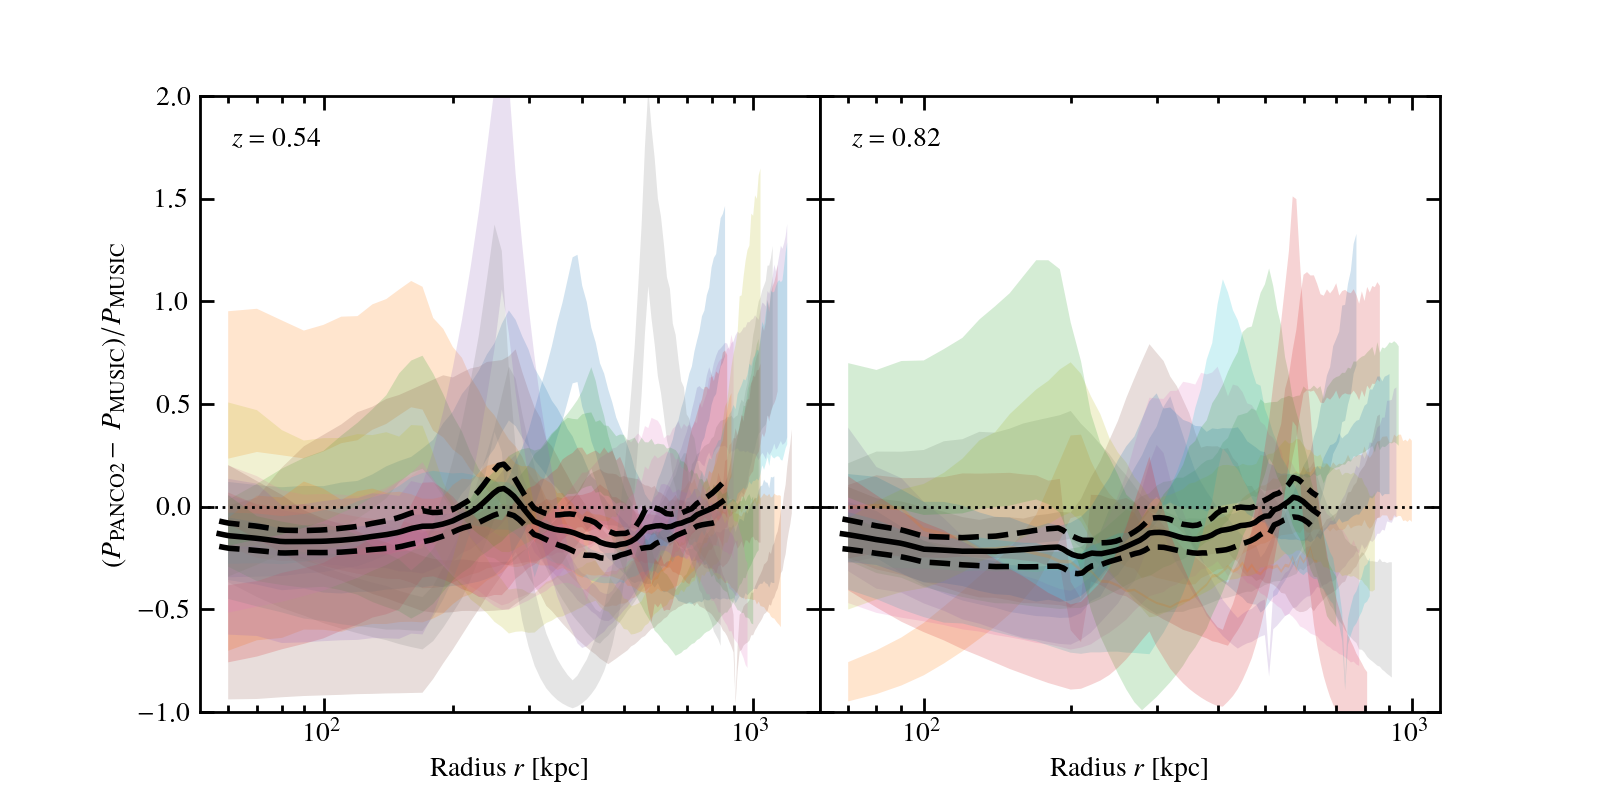

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

r = {}
for z in ['0.54', '0.82']:
    r[z] = np.logspace(
        np.log10(np.max([all_profs[c]['r_panco2'][0] for c in all_profs.keys() if z in c])),
        np.log10(np.min([all_profs[c]['r_panco2'][-2] for c in all_profs.keys() if z in c])),
        100
    )
all_diffs = {'0.54': [], '0.82': []}

for c in all_profs.keys():
    res = all_profs[c]
    p_panco2_interp = interp_powerlaw(res['r_panco2'], res['p_panco2'], res['r_music'])
    err_p_panco2_interp = interp_powerlaw(res['r_panco2'], res['err_p_panco2'], res['r_music'])

    diff = (p_panco2_interp - res['p_music']) / res['p_music']
    err = err_p_panco2_interp / res['p_music']
    msk = np.logical_and(res['r_music'] < res['r_panco2'][-2], res['r_music'] > res['r_panco2'][0])
    
    if "0.54" in c:
        ax = axs[0]
        all_diffs['0.54'].append(interp1d(res['r_music'], diff)(r['0.54']))
    else:
        ax = axs[1]
        all_diffs['0.82'].append(interp1d(res['r_music'], diff)(r['0.82']))
        
    ax.fill_between(res['r_music'][msk], (diff - err)[msk], (diff + err)[msk], alpha=0.2)

    
for z, ax in zip((0.54, 0.82), axs):
    ax.set_xscale('log')
    ax.set_ylim(-1.0, 2.0)
    ax.set_xlim(*ax.get_xlim())
    fkplotlib.ax_bothticks(ax)
    ax.set_xlabel(r"Radius $r \; [{\rm kpc}]$")
    ax.text(0.05, 0.95, f"$z = {z}$", transform=ax.transAxes, horizontalalignment='left', verticalalignment='top')
    
    ax.axhline(0.0, 0, 1, color="k", ls=":")
    mean = np.mean(all_diffs[str(z)], axis=0)
    std = np.std(all_diffs[str(z)], axis=0, ddof=1)
    n = len(all_diffs[str(z)])
    ax.plot(r[str(z)], mean, color="k", lw=2)
    ax.plot(r[str(z)], mean - std / np.sqrt(n), color="k", lw=2, ls="--")
    ax.plot(r[str(z)], mean + std / np.sqrt(n), color="k", lw=2, ls="--")

    
axs[0].set_ylabel(r"$(P_{\rm PANCO2} - \; P_{\rm MUSIC}) / P_{\rm MUSIC}$")
axs[1].set_yticklabels([])
fig.subplots_adjust(wspace=0)
fig.savefig("all_profiles_music_panco2_1.pdf")

# Interpolating MUSIC profile, difference relative to PANCO2 uncertainty

<IPython.core.display.Javascript object>


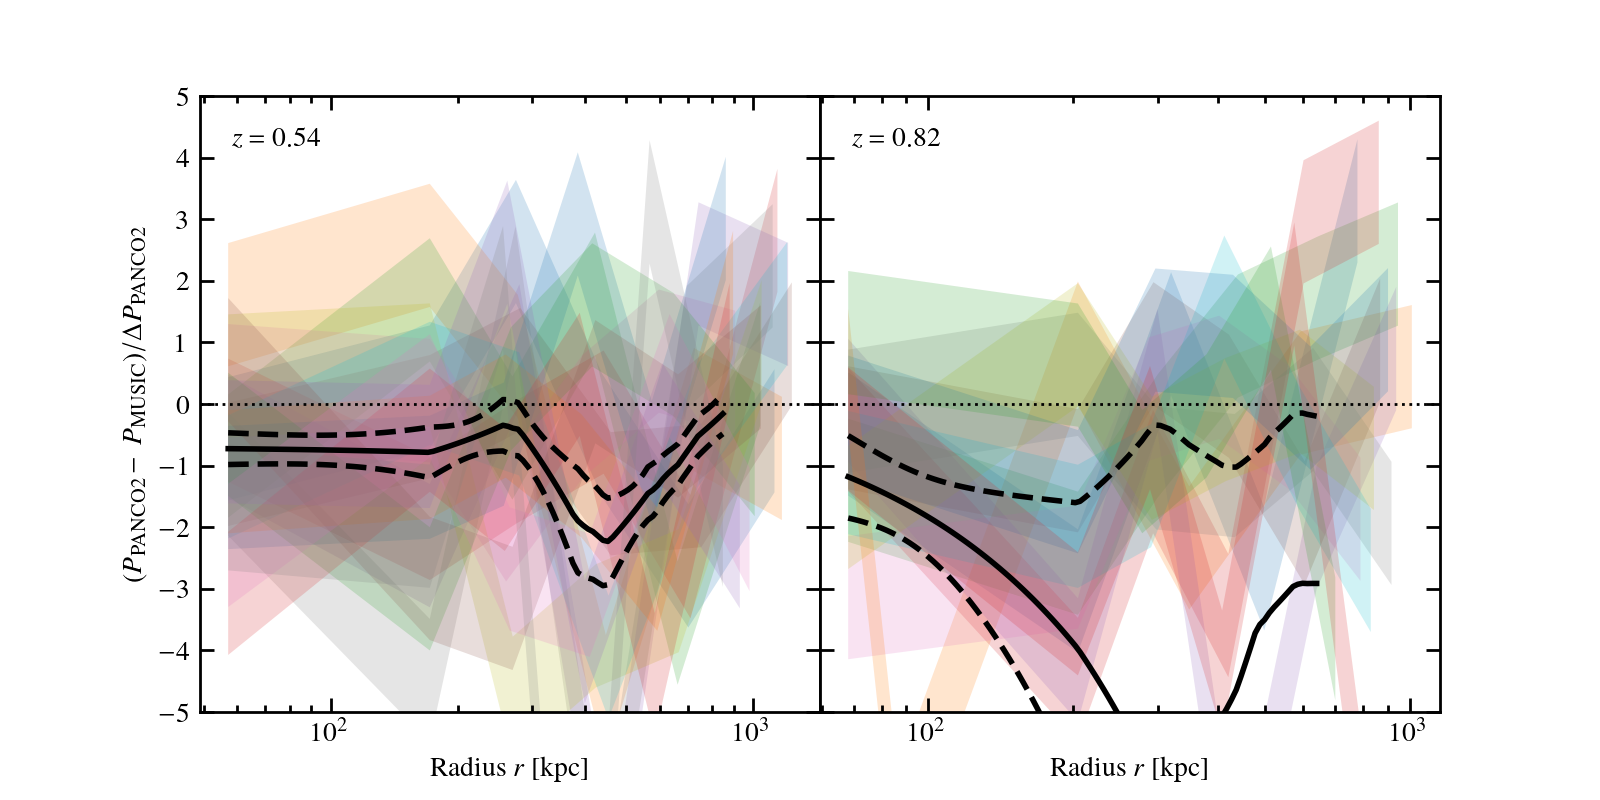

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

r = {}
for z in ['0.54', '0.82']:
    r[z] = np.logspace(
        np.log10(np.max([all_profs[c]['r_panco2'][0] for c in all_profs.keys() if z in c])),
        np.log10(np.min([all_profs[c]['r_panco2'][-2] for c in all_profs.keys() if z in c])),
        100
    )
all_diffs = {'0.54': [], '0.82': []}

for c in all_profs.keys():
    res = all_profs[c]
    p_music_interp = interp_powerlaw(res['r_music'], res['p_music'], res['r_panco2'])
    err_p_music_interp = interp_powerlaw(res['r_music'], res['err_p_music'], res['r_panco2'])

    #diff = (res['p_panco2'] - p_music_interp) / p_music_interp
    diff = (res['p_panco2'] - p_music_interp) / res['err_p_panco2']
    err = res['err_p_panco2'] / res['err_p_panco2']
    
    if "0.54" in c:
        ax = axs[0]
        all_diffs['0.54'].append(interp1d(res['r_panco2'], diff, fill_value="extrapolate")(r['0.54']))
    else:
        ax = axs[1]
        all_diffs['0.82'].append(interp1d(res['r_panco2'], diff, fill_value="extrapolate")(r['0.82']))
    
    msk = res['r_panco2'] < res['r_panco2'][-1]
    ax.fill_between(res['r_panco2'][msk], (diff - err)[msk], (diff + err)[msk], alpha=0.2)

    
for z, ax in zip((0.54, 0.82), axs):
    ax.set_xscale('log')
    ax.set_yticks(np.arange(-10, 10, 1.0))
    ax.set_ylim(-5.0, 5.0)
    ax.set_xlim(*ax.get_xlim())
    fkplotlib.ax_bothticks(ax)
    ax.set_xlabel(r"Radius $r \; [{\rm kpc}]$")
    ax.text(0.05, 0.95, f"$z = {z}$", transform=ax.transAxes, horizontalalignment='left', verticalalignment='top')
    
    ax.axhline(0.0, 0, 1, color="k", ls=":")
    mean = np.mean(all_diffs[str(z)], axis=0)
    std = np.std(all_diffs[str(z)], axis=0, ddof=1)
    n = len(all_diffs[str(z)])
    ax.plot(r[str(z)], mean, color="k", lw=2)
    ax.plot(r[str(z)], mean - std / np.sqrt(n), color="k", lw=2, ls="--")
    ax.plot(r[str(z)], mean + std / np.sqrt(n), color="k", lw=2, ls="--")
    #perc = np.percentile(all_diffs[str(z)], [16, 50, 84], axis=0)
    #ax.plot(r[str(z)], perc[1], color="k", lw=2)
    #ax.plot(r[str(z)], perc[0], color="k", lw=2, ls="--")
    #ax.plot(r[str(z)], perc[2], color="k", lw=2, ls="--")

    
axs[0].set_ylabel(r"$(P_{\rm PANCO2} - \; P_{\rm MUSIC}) / \Delta P_{\rm PANCO2}$")
axs[1].set_yticklabels([])
fig.subplots_adjust(wspace=0)
fig.savefig("all_profiles_music_panco2_2.pdf")

# Same as above separated in disturbed/relaxed

<IPython.core.display.Javascript object>


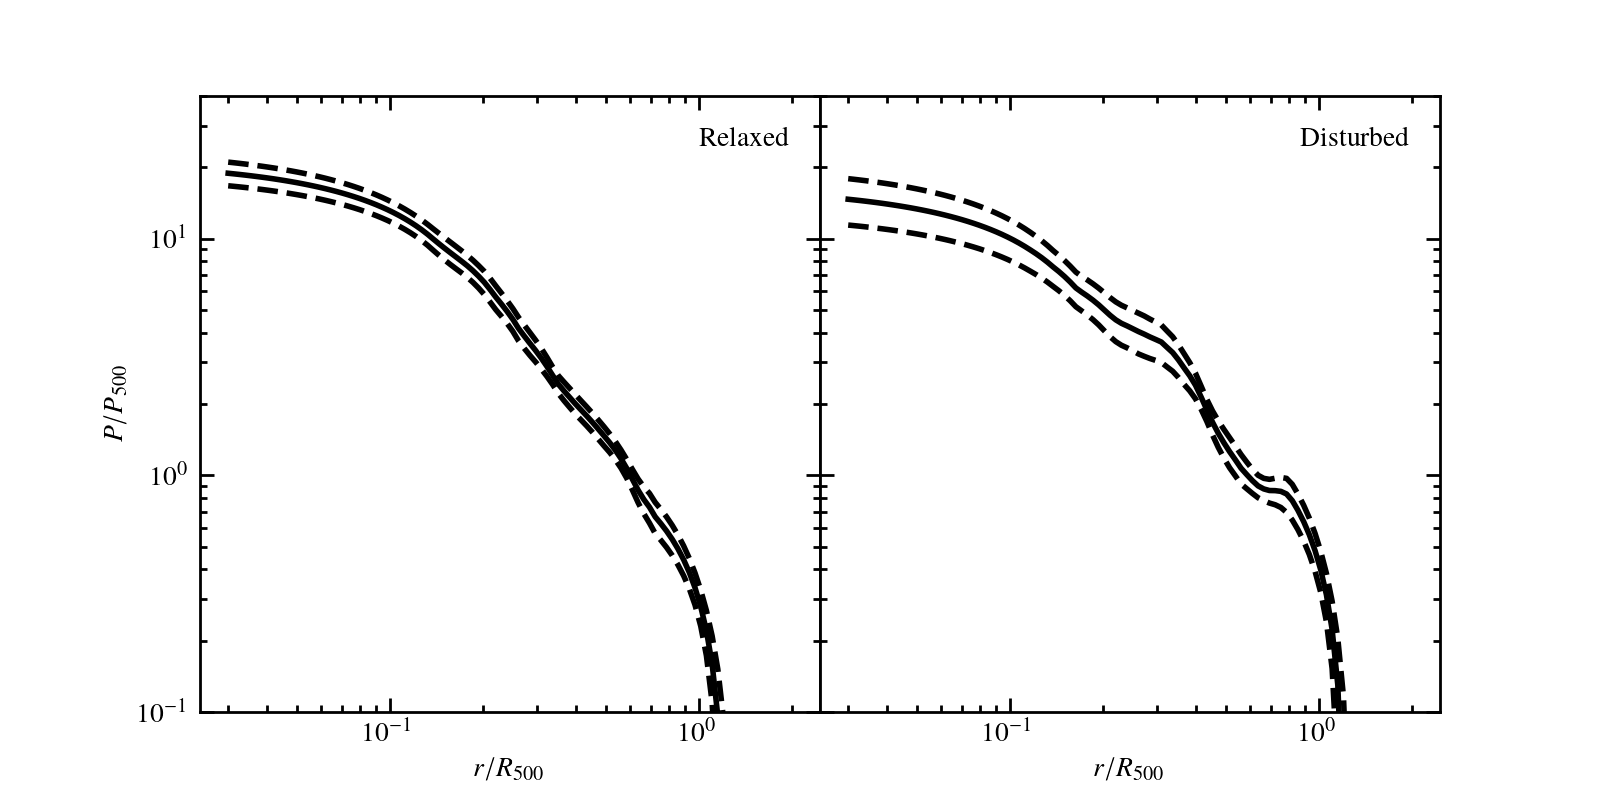

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

r = np.logspace(np.log10(3e-2), np.log10(2), 100)
cluster_list["rel_diff"] = [[] for _ in cluster_list.iloc]
for c in all_profs.keys():
    res = all_profs[c]
    p_music_interp = interp_powerlaw(res['r_music'], res['p_music'], res['r_panco2'])
    msk = slice(0, -1)
    diff = (res['p_panco2'][msk] - p_music_interp[msk]) / res['err_p_panco2'][msk]
    P500 = 1.65e-3 * cosmo.efunc(cluster_list["z"][i]) ** (8/3) * (cluster_list["M_500"][i] / 3e14)**(2/3)
    diff = res['p_panco2'][msk] / P500
    i = np.where(np.logical_and(cluster_list["name"] == int(c[0:5]), cluster_list["z"] == float(c[6:10])))[0][0]
    ax = axs[0] if cluster_list["state"][i] == "rel" else axs[1]
    
    #ax.plot(1e-3 * res['r_panco2'][msk] / cluster_list['R_500'][i], diff, alpha=0.5)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cluster_list['rel_diff'][i] = interp1d(
            1e-3 * res['r_panco2'][msk] / cluster_list['R_500'][i], 
            diff, 
            fill_value="extrapolate"
        )(r)

diffs_rel = np.array([cl['rel_diff'] for cl in cluster_list.iloc() if cl['state'] == 'rel'])
diffs_dist = np.array([cl['rel_diff'] for cl in cluster_list.iloc() if cl['state'] == 'dist'])

#axs = [axs[0], axs[0]]
for ax, diff in zip(axs, [diffs_rel, diffs_dist]):
    #ax.plot(r, np.percentile(diff, 50, axis=0), color="k", lw=2)
    #ax.plot(r, np.percentile(diff, 16, axis=0), color="k", lw=2, ls="--")
    #ax.plot(r, np.percentile(diff, 84, axis=0), color="k", lw=2, ls="--")
    ax.plot(r, np.mean(diff, axis=0), color="k", lw=2)
    ax.plot(r, np.mean(diff, axis=0) - np.std(diff, axis=0, ddof=1) / np.sqrt(diff.shape[0]), color="k", lw=2, ls="--")
    ax.plot(r, np.mean(diff, axis=0) + np.std(diff, axis=0, ddof=1) / np.sqrt(diff.shape[0]), color="k", lw=2, ls="--")
    
for ax, state in zip(axs, ["Relaxed", "Disturbed"]):
    ax.set_ylim(0.1, 40)
    ax.set_yscale('log')
    ax.set_xscale("log")
    #ax.grid(axis="y")
    ax.set_xlabel(r"$r / R_{500}$")
    ax.text(0.95, 0.95, state, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    fkplotlib.ax_bothticks(ax)

axs[0].set_ylabel(r"$P / P_{500}$")
axs[1].set_yticklabels([])
fig.subplots_adjust(wspace=0)
fig.savefig("all_profiles_music_panco2_2.pdf")

In [10]:
cluster_list

,name,z,state,R_500,M_500,rel_diff
0,6,0.54,rel,1.08482,6.567250e+14,"[1.4048309918614597, 1.4167068329534014, 1.429..."
1,7,0.54,rel,0.99853,5.121460e+14,"[-1.449288788749066, -1.4204970910969417, -1.3..."
2,24,0.54,rel,1.16585,8.151660e+14,"[0.046311220742378034, 0.02517757324275427, 0...."
3,26,0.54,rel,1.23144,9.606320e+14,"[-0.2136466786707324, -0.2384649756082769, -0...."
4,32,0.54,rel,0.85059,3.165780e+14,"[0.36443232792065505, 0.36209016449331277, 0.3..."
5,47,0.54,rel,1.10606,6.960670e+14,"[-0.43544093940382655, -0.4775686236983032, -0..."
6,156,0.54,rel,0.79310,2.566240e+14,"[-1.4049554019307513, -1.4034461212304963, -1...."
7,174,0.54,rel,1.03877,5.766020e+14,"[0.07874148732461828, 0.049117705695414626, 0...."
8,240,0.54,rel,0.93685,4.229860e+14,"[-2.912547904637812, -2.8866866260395287, -2.8..."
9,5,0.54,dist,1.02730,5.577100e+14,"[-0.758534268225485, -0.7487178223532678, -0.7..."


In [28]:
cosmo.comoving_volume(0.5)
(4 * np.pi / 3) * cosmo.comoving_distance(0.5)**3

<Quantity 3.0888444e+10 Mpc3>